# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train

array([[ 2.59309503,  2.95605525, -1.40506097, ...,  0.73760417,
        -0.56740135,  0.4529528 ],
       [-1.51718864, -2.46083539,  0.97109625, ...,  1.01493591,
         1.93929981, -0.39093856],
       [ 1.60701555,  1.07420377, -0.58666797, ..., -0.29366553,
         0.66675842,  0.60867293],
       ...,
       [ 1.50205531,  0.7582237 ,  1.09919181, ...,  0.41914376,
         0.95720133, -0.08123232],
       [ 2.42706399,  1.63049568,  0.02863036, ...,  0.92701011,
         1.42529366,  0.35650895],
       [ 0.86662177, -1.37515951,  1.37750592, ...,  1.51649724,
         1.23166353, -0.85468423]])

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?

**Ответ**: Потому что y_target предсказывает с какой вероятностью принадлежит x_i к положительному и отрицательному классу.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


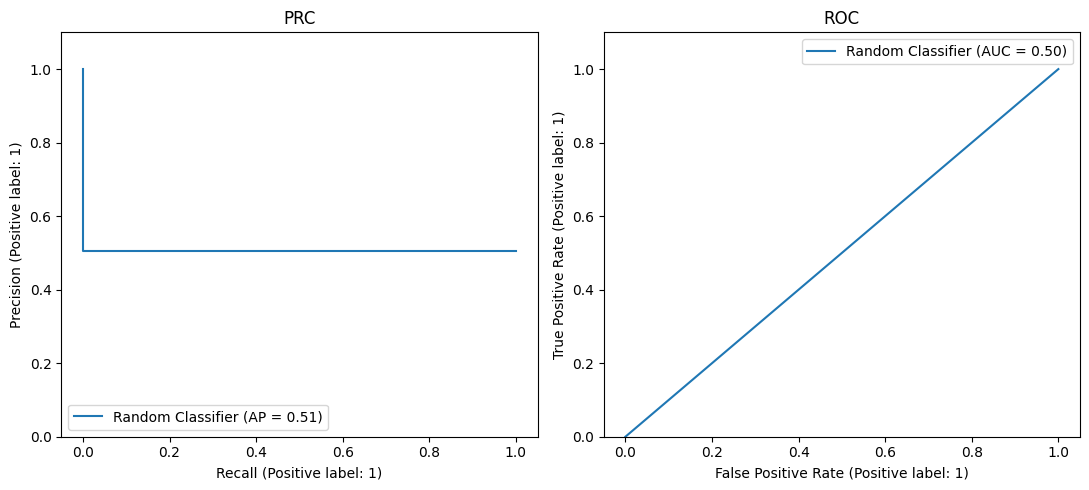

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

        print(classifier_name, 'metrics')
        PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
        print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
        ax[0].set_title("PRC")
        ax[0].set_ylim(0, 1.1)

        RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
        print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
        ax[1].set_title("ROC")
        ax[1].set_ylim(0, 1.1)

        plt.tight_layout()
        plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, random_state=42)

C_val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

max_auc_pr = -float('inf')
best_C = 0

for C in C_val:
    svc = LinearSVC(random_state=42, C=C, max_iter=20000, dual='auto')
    
    svc.fit(X_train, y_train)
    
    y_val_pred = svc.decision_function(X_val)
    auc_pr = average_precision_score(y_val, y_val_pred)
    
    if auc_pr > max_auc_pr:
        max_auc_pr = auc_pr
        best_C = C

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

Support Vector Machine metrics
AUC-PR: 0.8284
AUC-ROC: 0.8473


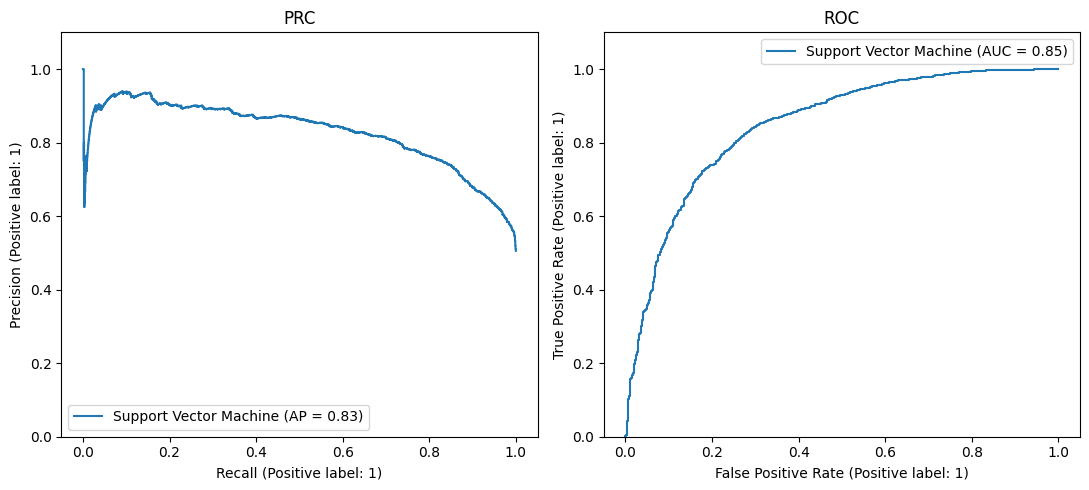

In [10]:
best_svc = LinearSVC(random_state=42, C=best_C, dual='auto', max_iter=20000)

best_svc.fit(X_train, y_train)

y_pred_svm = best_svc.decision_function(X_test)

depict_pr_roc(y_test, y_pred_svm, classifier_name='Support Vector Machine')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
df_metrics.loc['Support Vector Machine'] = [
      average_precision_score(y_test, y_pred_svm),
      roc_auc_score(y_test, y_pred_svm),
      best_C,
]        

df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000
Support Vector Machine,0.828410,0.847311,0.001


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [12]:
from sklearn.linear_model import LogisticRegression

C_val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

max_auc_pr = -float('inf')
best_C_log_reg = 0

for C in C_val:
    log_reg = LogisticRegression(random_state=42, C=C, max_iter=20000)
    
    log_reg.fit(X_train, y_train)
    
    y_val_pred = log_reg.decision_function(X_val)
    auc_pr = average_precision_score(y_val, y_val_pred)
    
    if auc_pr > max_auc_pr:
        max_auc_pr = auc_pr
        best_C_log_reg = C

Logistic Regression metrics
AUC-PR: 0.8332
AUC-ROC: 0.8451


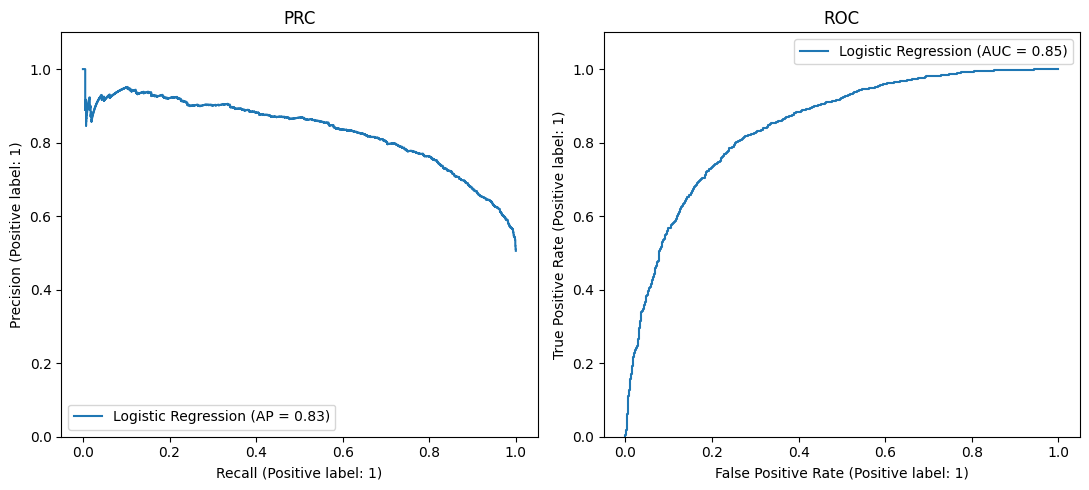

In [13]:
best_log_reg = LogisticRegression(random_state=42, C=best_C_log_reg, max_iter=20000)

best_log_reg.fit(X_train, y_train)
y_pred_log_reg = best_log_reg.decision_function(X_test)

depict_pr_roc(y_test, y_pred_log_reg, classifier_name='Logistic Regression')

In [14]:
df_metrics.loc['Logistic Regression'] = [
      average_precision_score(y_test, y_pred_log_reg),
      roc_auc_score(y_test, y_pred_log_reg),
      best_C_log_reg,
]        

df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000
Support Vector Machine,0.828410,0.847311,0.001
Logistic Regression,0.833230,0.845058,0.001


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

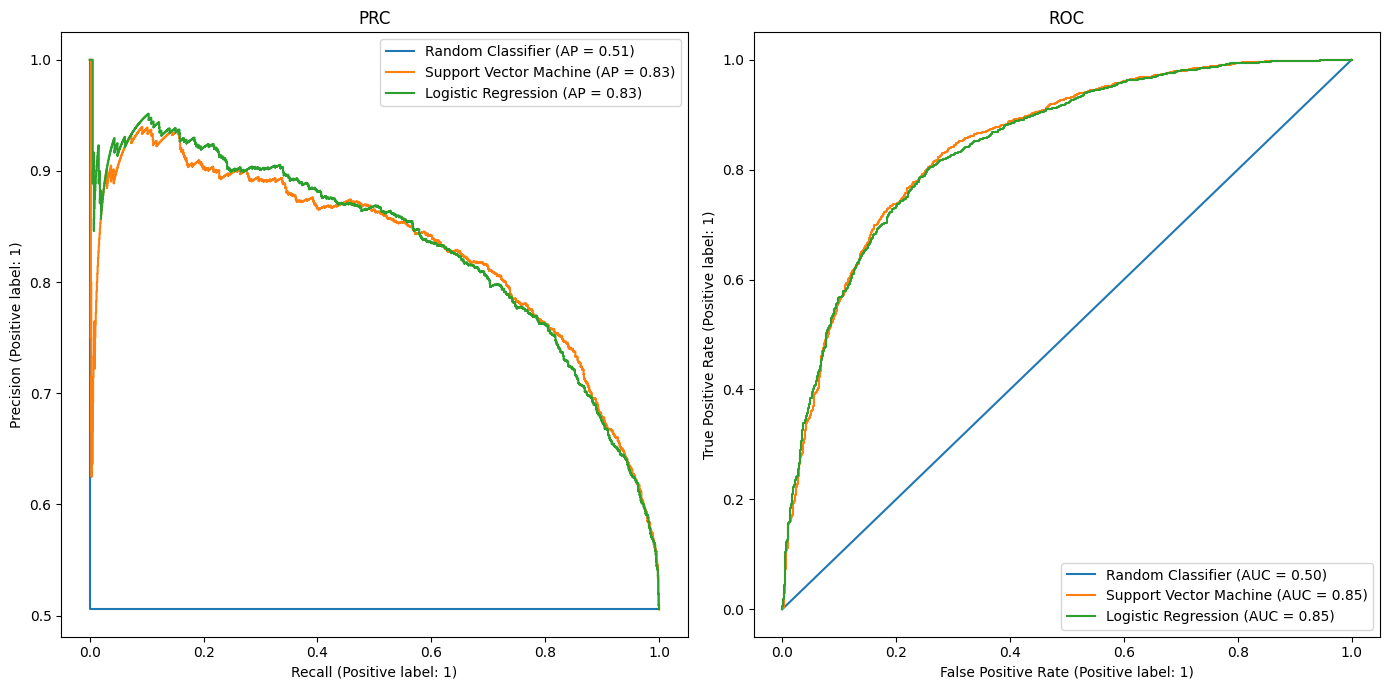

In [17]:
predictions_dict = {
    "Random Classifier": y_random,
    "Support Vector Machine": y_pred_svm,
    "Logistic Regression": y_pred_log_reg,
}
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    
for classifier_name, y_pred in predictions_dict.items():
    PrecisionRecallDisplay.from_predictions(
        y_test, y_pred, ax=ax[0], name=classifier_name
    )
    RocCurveDisplay.from_predictions(
        y_test, y_pred, ax=ax[1], name=classifier_name
    )
    
ax[0].set_title('PR')
ax[0].legend(loc="upper right")
    
ax[1].set_title("ROC")
ax[1].legend(loc="lower right")
    
plt.tight_layout()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** обе модели показывают почти идентичные результаты по PRC и ROC метрикам.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [22]:
from sklearn.svm import SVC

X, y = make_classification(
    n_samples=10000, n_features=2, n_redundant=0, n_informative=2, random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

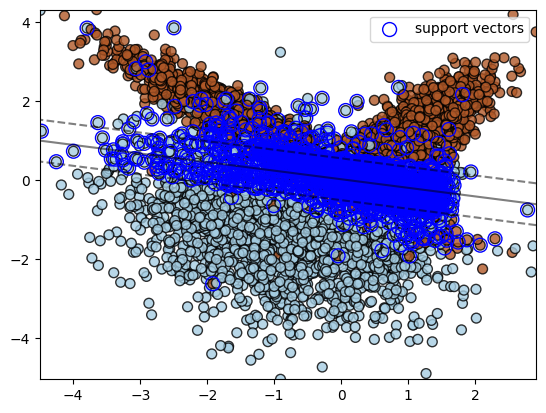

In [24]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)# your code here

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=50, alpha=0.8, edgecolor='k')# your code here

    
    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0], 
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорными векторами становятся точки, которые либо находятся на самой границе, либо пересекают её. Они "двигают" гиперплоскость, отступ, определяют точки на границе и ошибочные точки.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

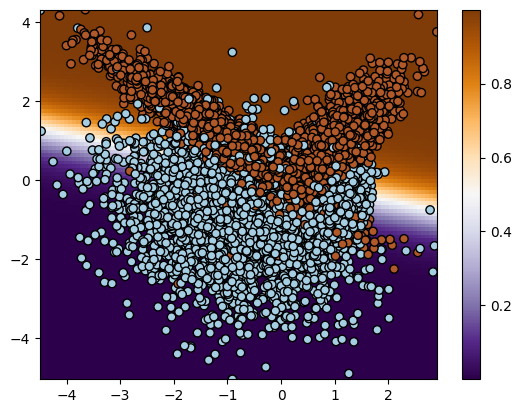

In [25]:
model = LogisticRegression(random_state=42)
model.fit(X, y)


def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]# your code here
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=y, 
        edgecolor='k',# your code here
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Она визуализирована белым цветом(белая полоса), то есть это разделяющая гиперплоскость, в ответах которой модель максимальна неуверена

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [18]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [19]:
from scipy.special import expit

SVM calibration curve
LR calibration curve


/Users/semyonzotov/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/semyonzotov/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


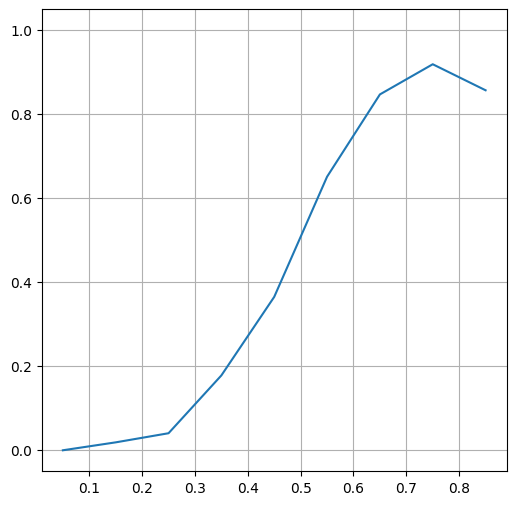

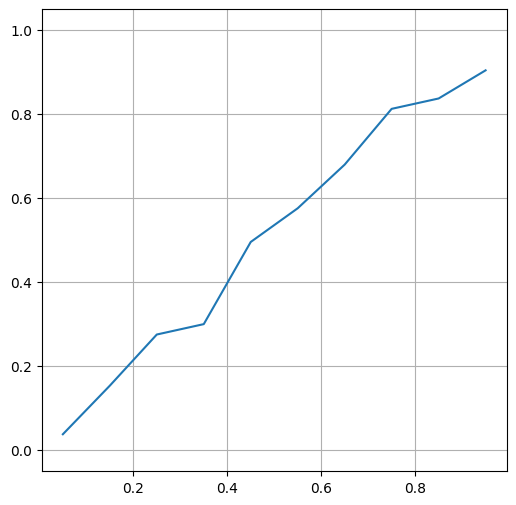

In [20]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = LinearSVC(random_state=42, dual='auto') 
svm.fit(X_train, y_train)
svm_preds = svm.decision_function(X_test)
print('SVM calibration curve')
svm_preds = expit(svm_preds)
plot_calibration_curve(y_test, svm_preds)


lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict_proba(X_test)[:, 1]
print('LR calibration curve')
plot_calibration_curve(y_test, lr_preds)

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Критерий хорошой калибровки кривой это близость к диагонали. Кривая для логистической регрессии лучше откалибрована, нежели SVM.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [21]:
from sklearn.metrics import log_loss, brier_score_loss

In [24]:
logloss_lr = log_loss(y_test, lr_preds)
logloss_svm = log_loss(y_test, svm_preds)

brier_lr = brier_score_loss(y_test, lr_preds)
brier_svm = brier_score_loss(y_test, svm_preds)

print("LogLoss Logistic Regression:", logloss_lr)
print("LogLoss SVM:", logloss_svm)
print("Brier Score Logistic Regression:", brier_lr)
print("Brier Score SVM:", brier_svm)

LogLoss Logistic Regression: 0.4858547138605954
LogLoss SVM: 0.5520712135729844
Brier Score Logistic Regression: 0.15858324761523218
Brier Score SVM: 0.18316547688479232


Изучите распределение ответов классификаторов при помощи гистограмм

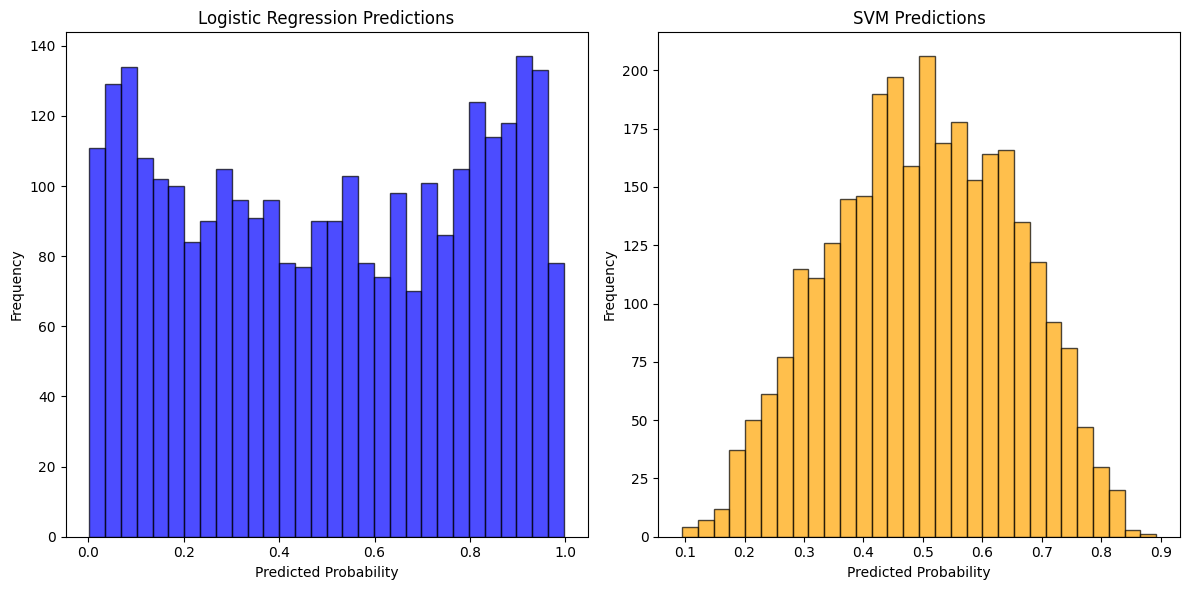

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(lr_preds, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Logistic Regression Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(svm_preds, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title("SVM Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Видно, что SVM более сглажено, в то время как LR имеет большую частоту на краях вероятностной прямой. С LR понятно, что по краям она более уверена в прогнозах, а ближе к середине - менее. В свою очередь SVM обучается минимизировать расстояние до разделяющей границы с целью разделения классов, её "уверенность" не интерпретируется как вероятность. В результате распределение предсказаний сосредотачивается ближе к середине

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

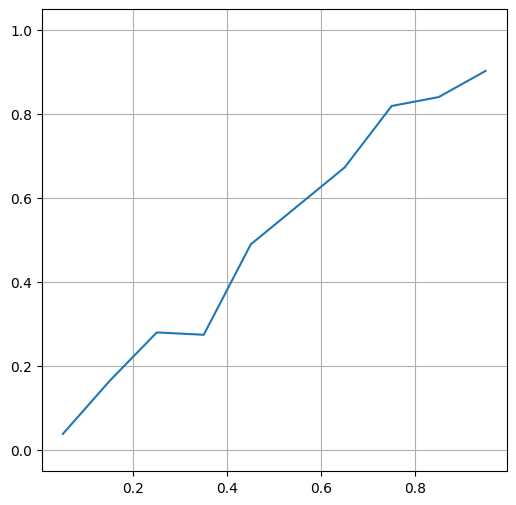

In [26]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(svm, cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_preds = calibrated_clf.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, calibrated_preds)

In [27]:
logloss_svm = log_loss(y_test, calibrated_preds)
brier_svm = brier_score_loss(y_test, calibrated_preds)

print(f"LogLoss (SVM): {logloss_svm:.4f}")
print(f"Brier Score (SVM): {brier_svm:.4f}")

LogLoss (SVM): 0.4862
Brier Score (SVM): 0.1587


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да и да, все видно на графике и на результатах

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [28]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [29]:
# Прочитаем датасет
# your code here
df = pd.read_csv(path)

# Заменим пропуски категориальных переменных
# your code here
categorical_columns = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
df[categorical_columns] = df[categorical_columns].fillna("undefined")

y = df['Purchased Bike']
X = df.drop('Purchased Bike', axis=1)

X_numerical = X[['Income', 'Age', 'Children', 'Cars']]
X_categorical = X[categorical_columns].astype('str')

В начале поработаем только с категориальными признаками

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [34]:
import time
from sklearn.preprocessing import OrdinalEncoder

ordinalencoder = OrdinalEncoder()
y_train_upd = y_train.replace({'Yes': 1, 'No': 0})
y_test_upd = y_test.replace({'Yes': 1, 'No': 0})

start = time.time()

X_train_encoded = ordinalencoder.fit_transform(X_train)
X_test_encoded = ordinalencoder.transform(X_test)

model = LogisticRegression(max_iter=10000, random_state=777)
model.fit(X_train_encoded, y_train)

end = time.time()

y_pred = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test_upd, y_pred)

In [35]:
res = pd.DataFrame(
    columns=['auc_pr', 'time']
)

res.loc['OrdinalEncoder'] = [
      auc_pr,
      end - start
]
res

,auc_pr,time
OrdinalEncoder,0.588301,0.016303


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [36]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()

start = time.time()

X_train_encoded = onehotencoder.fit_transform(X_train)
X_test_encoded = onehotencoder.transform(X_test)

model = LogisticRegression(max_iter=10000, random_state=777)
model.fit(X_train_encoded, y_train_upd)

end = time.time()

y_pred = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test_upd, y_pred)

In [37]:
res.loc['One-Hot Encoder'] = [
      auc_pr,
      end - start
]
res

,auc_pr,time
OrdinalEncoder,0.588301,0.016303
One-Hot Encoder,0.666643,0.023201


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [38]:
# your code here
X_train_MTE = X_train.copy()
X_test_MTE = X_test.copy()
y_train_upd = y_train.replace({'Yes': 1, 'No': 0})

start = time.time()

for x in X_train_MTE.columns:
    mean_target = pd.concat([X_train_MTE, y_train_upd], axis = 1).groupby(x)['Purchased Bike'].mean()
    
    X_train_MTE[x] = X_train_MTE[x].map(mean_target)
    X_test_MTE[x] = X_test_MTE[x].map(mean_target)

model = LogisticRegression(max_iter=10000, random_state=777)
model.fit(X_train_MTE, y_train_upd)

end = time.time()

y_pred = model.predict_proba(X_test_MTE)[:, 1]

auc_pr = average_precision_score(y_test_upd, y_pred)

In [39]:
res.loc['Mean-target Encoding'] = [
      auc_pr,
      end - start
]
res

,auc_pr,time
OrdinalEncoder,0.588301,0.016303
One-Hot Encoder,0.666643,0.023201
Mean-target Encoding,0.657541,0.026732


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [68]:
# your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [40]:
X_train_MTE_noise = X_train.copy()
X_test_MTE_noise = X_test.copy()

start = time.time()

for x in X_train_MTE_noise.columns:
    mean_target = pd.concat([X_train_MTE_noise, y_train_upd], axis = 1).groupby(x)['Purchased Bike'].mean()
    
    noise = np.random.normal(0, 0.01, mean_target.shape)
    
    X_train_MTE_noise[x] = X_train_MTE_noise[x].map(mean_target + noise)
    X_test_MTE_noise[x] = X_test_MTE_noise[x].map(mean_target + noise)

model = LogisticRegression(max_iter=10000, random_state=777)
model.fit(X_train_MTE_noise, y_train_upd)

end = time.time()

y_pred = model.predict_proba(X_test_MTE_noise)[:, 1]

auc_pr = average_precision_score(y_test_upd, y_pred)

In [41]:
res.loc['Mean-target Encoding + Noise'] = [
      auc_pr,
      end - start
]
res

,auc_pr,time
OrdinalEncoder,0.588301,0.016303
One-Hot Encoder,0.666643,0.023201
Mean-target Encoding,0.657541,0.026732
Mean-target Encoding + Noise,0.659124,0.023058


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Немного помогло, так как шум помогает модели не слишком точно запоминать каждый элемент тренировочных данных, и она учится обобщать, что улучшает её способность делать более точные прогнозы на новых данных. Но с шумом лучше не перебарщивать.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [42]:
X_train_MTE_C = X_train.copy()
X_test_MTE_C = X_test.copy()

global_mean = y_train_upd.mean()

C_values = [0.1, 1, 10, 100, 1000]
best_C = None
best_score = -1


for C in C_values:
    
    for x in X_train_MTE_C.columns:
        help_agg = pd.concat([X_train_MTE_C, y_train_upd], axis = 1).groupby(x)['Purchased Bike'].agg(['sum', 'count'])
        a = (help_agg['sum'] + C * global_mean) / (help_agg['count'] + C)
        X_train_MTE_C[x] = X_train_MTE_C[x].map(a)
        X_test_MTE_C[x] = X_test_MTE_C[x].map(a)
    
    model = LogisticRegression(max_iter=10000, random_state=777)
    model.fit(X_train_MTE_C, y_train_upd)

    y_pred = model.predict_proba(X_test_MTE_C)[:, 1]

    auc_pr = average_precision_score(y_test_upd, y_pred)
    
    if auc_pr > best_score:
        best_C = C
        best_score = auc_pr

In [45]:
res.loc['Сглаживание счетчиков'] = [
      best_score,
    0
]
res

,auc_pr,time
OrdinalEncoder,0.588301,0.016303
One-Hot Encoder,0.666643,0.023201
Mean-target Encoding,0.657541,0.026732
Mean-target Encoding + Noise,0.659124,0.023058
Сглаживание счетчиков,0.672057,0.000000


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [61]:
Q1 = X_numerical.quantile(0.15)
Q3 = X_numerical.quantile(0.85)
q = Q3 - Q1

l_b = Q1 - 1.5 * q
u_b = Q3 + 1.5 * q

outliers = (X_numerical < l_b) | (X_numerical > u_b)

X_numerical[outliers.any(axis=1)]

,Income,Age,Children,Cars
6,160000.0,33.0,2.0,4.0
12,170000.0,55.0,5.0,NaN
43,170000.0,48.0,4.0,3.0
178,160000.0,55.0,4.0,2.0
321,160000.0,47.0,0.0,3.0
829,170000.0,66.0,1.0,4.0


Выбросы есть

In [62]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_numerical = pd.DataFrame(imputer.fit_transform(X_numerical), columns=X_numerical.columns)

X_numerical.isna().sum()

Income      0
Age         0
Children    0
Cars        0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [63]:
print(X_numerical.nunique().sum())

80


In [64]:
X_train_num, X_test_num = train_test_split(X_numerical, test_size=0.25, random_state=777, stratify=y)

In [65]:
for x in X_train_num.columns:
    C = 10
    help_agg = pd.concat([X_train_num, y_train_upd], axis = 1).groupby(x)['Purchased Bike'].agg(['sum', 'count'])
    a = (help_agg['sum'] + C * global_mean) / (help_agg['count'] + C)
    X_train_num[x] = X_train_num[x].map(a)
    X_test_num[x] = X_test_num[x].map(a)

In [66]:
X_train = pd.concat([X_train_MTE_C, X_train_num], axis=1)
X_test = pd.concat([X_test_MTE_C, X_test_num], axis=1)

In [67]:
model = LogisticRegression(max_iter=10000, random_state=777)
model.fit(X_train, y_train_upd)

y_pred = model.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test_upd, y_pred)

print(auc_pr)

0.643260483487433


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Из очевидных плюсов это уменьшение признаков, а точнее неизменяемость количества признаков. Каких то супер приращений в качестве не обнаружено. Из минусов нам всегда нужен таргет.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [68]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 16:50:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «adult.data.5»

adult.data.5            [        <=>         ]   3,79M  1,62MB/s    за 2,3s    

2024-11-28 16:50:57 (1,62 MB/s) - «adult.data.5» сохранён [3974305]



In [198]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
26950,31,State-gov,100863,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,50,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [199]:
y = df['income']
X = df.drop('income', axis=1)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [201]:
from sklearn.preprocessing import OneHotEncoder

In [202]:
categorical_columns = ['workclass', 'education',
    'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

ohe = OneHotEncoder(handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train[categorical_columns])
X_test_ohe = ohe.transform(X_test[categorical_columns])

num_features_without_ohe = X_train.shape[1]
num_features_with_ohe = X_train_ohe.shape[1]
print('Количество новых признаков: ', num_features_with_ohe)

Количество новых признаков:  102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [203]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_ohe, y_train)
y_pred = model.predict(X_test_ohe)

auc_pr = average_precision_score(y_test, y_pred)
print('Average Precision Score: ', auc_pr)

Average Precision Score:  0.48834992050498305


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [204]:
import scipy.sparse as sparse

In [205]:
best_40 = np.argsort(np.abs(model.coef_[0]))[::-1][:40]

X_train_best_40 = X_train_ohe[:, best_40]
X_test_best_40 = X_test_ohe[:, best_40]

model_9 = LogisticRegression(max_iter=10000)
model_9.fit(X_train_best_40, y_train)
y_pred = model_9.predict(X_test_best_40)

auc_pr = average_precision_score(y_test, y_pred)
auc_pr

0.4702870570515203

Изменилось ли качество? Как?

**Ответ:** да, ухудшилось((

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [206]:
from sklearn.preprocessing import StandardScaler

In [207]:
numeric_columns = ['age', 'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss', 'hours-per-week']

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

from scipy.sparse import hstack

X_train_final = hstack([X_train_scaled, X_train_ohe])
X_test_final = hstack([X_test_scaled, X_test_ohe])

In [208]:
best_40 = np.argsort(np.abs(model_9.coef_[0]))[::-1][:40]

X_train_best_40 = X_train_final.toarray()[:, best_40]
X_test_best_40 = X_test_final.toarray()[:, best_40]

model_9_1 = LogisticRegression(max_iter=10000)
model_9_1.fit(X_train_best_40, y_train)
y_pred = model_9_1.predict(X_test_best_40)

auc_pr = average_precision_score(y_test, y_pred)
auc_pr

0.5198068438936354

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [209]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train_ohe.toarray())
X_test_scaled = scaler.transform(X_test_ohe.toarray())

In [210]:
best_40 = np.argsort(np.abs(model_9.coef_[0]))[::-1][:40]

X_train_best_40 = X_train_scaled[:, best_40]
X_test_best_40 = X_test_scaled[:, best_40]

model = LogisticRegression(max_iter=10000)
model.fit(X_train_best_40, y_train)
y_pred = model.predict(X_test_best_40)

auc_pr = average_precision_score(y_test, y_pred)
auc_pr

0.46519387282456776

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** чем сильнее признак коррелирует с целевой переменной, тем больше он "влияет" на нее. Но для нелинейных моделей, может показывать большую корреляцию, указывая на линейную зависимость, что неверно. 

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [213]:
start = time.time()

correlations = np.abs(np.corrcoef(X_train_final.toarray(), rowvar=False)[-1][:-1])

best_40_corr = np.argsort(correlations)[::-1][:40]

X_train_best_40 = X_train_final_array[:, best_40_corr]
X_test_best_40 = X_test_final.toarray()[:, best_40_corr]

model = LogisticRegression(max_iter=10000)
model.fit(X_train_best_40, y_train)
y_pred = model.predict(X_test_best_40)

auc_pr = average_precision_score(y_test, y_pred)
print('auc_pr', auc_pr)

end = time.time()
print('time:', end - start)

auc_pr 0.4936717311933041
time: 0.5071358680725098


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [216]:
def t_stat(X, y):
    t_stats = []
    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    
    for j in range(X.shape[1]):
        X_pos = X[y == 1, j]
        X_neg = X[y == 0, j]
        
        mu_pos = np.mean(X_pos)
        mu_neg = np.mean(X_neg)
        sigma_pos = np.std(X_pos)
        sigma_neg = np.std(X_neg)
        
        t_stat = abs(mu_pos - mu_neg) / np.sqrt(((sigma_pos**2 * n_pos) + (sigma_neg**2 * n_neg)) / (n_pos + n_neg))
        t_stats.append(t_stat)
    
    return np.array(t_stats)

start = time.time()

t_stats = t_stat(X_train_final.toarray(), y_train)

best_40_t_stat = np.argsort(t_stats)[::-1][:40]

X_train_best_40 = X_train_final.toarray()[:, best_40_t_stat]
X_test_best_40 = X_test_final.toarray()[:, best_40_t_stat]

model = LogisticRegression(max_iter=10000)
model.fit(X_train_best_40, y_train)

y_pred = model.predict(X_test_best_40)

auc_pr = average_precision_score(y_test, y_pred)
print('auc_pr: ', auc_pr)

end = time.time()
print('time:', end - start)

auc_pr:  0.5253760973781797
time: 0.5741770267486572


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [222]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

ohe = OneHotEncoder(handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train[categorical_columns])
X_val_ohe = ohe.transform(X_val[categorical_columns])
X_test_ohe = ohe.transform(X_test[categorical_columns])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_val_scaled = scaler.transform(X_val[numeric_columns])
X_test_scaled = scaler.transform(X_test[numeric_columns])

X_train_final = hstack([X_train_scaled, X_train_ohe])
X_val_final = hstack([X_val_scaled, X_val_ohe])
X_test_final = hstack([X_test_scaled, X_test_ohe])

In [227]:
def wrapper_methods(X_train, y_train, X_val, y_val, X_test, y_test, k, m):
    start = time.time()
    
    current_features = np.arange(X_train.shape[1])
    
    model = LogisticRegression(max_iter=10000)
    
    while len(current_features) > k:
        model.fit(X_train[:, current_features], y_train)
        
        importance = np.abs(model.coef_[0])
        
        sorted_idx = np.argsort(importance)
        features_to_remove = sorted_idx[:m]
        
        current_features = np.delete(current_features, features_to_remove)
        
        if len(current_features) <= k:
            break

    model.fit(X_train[:, current_features], y_train)
    y_pred_val = model.predict(X_val[:, current_features])
    auc_pr_val = average_precision_score(y_val, y_pred_val)

    model.fit(X_train[:, current_features], y_train)
    y_pred_test = model.predict(X_test[:, current_features])
    auc_pr_test = average_precision_score(y_test, y_pred_test)
    
    end = time.time()
    print('m:', m)
    print('time: ', end - start)
    
    return auc_pr_val, auc_pr_test, current_features

def tune_step_size(X_train, y_train, X_val, y_val, X_test, y_test, k, m_values):
    best_auc_pr_val = -np.inf
    best_auc_pr_test = -np.inf
    best_m = None
    best_selected_features = None

    for m in m_values:
        auc_pr_val, auc_pr_test, selected_features = greedy_feature_selection(X_train, y_train, X_val, y_val, X_test, y_test, k, m)
        if auc_pr_val > best_auc_pr_val:
            best_auc_pr_val = auc_pr_val
            best_auc_pr_test = auc_pr_test
            best_m = m
            best_selected_features = selected_features
    
    print("best m: ", best_m) 
    print("auc_pr: ", best_auc_pr_test)

k = 40
m_values = [2, 5, 8, 10, 13, 15, 18, 20, 25]  
tune_step_size(X_train_final.toarray(), y_train, X_val_final.toarray(), y_val, X_test_final.toarray(), y_test, k, m_values)


m: 2
time:  21.23561692237854
m: 5
time:  11.497212886810303
m: 8
time:  5.390695095062256
m: 10
time:  5.578552007675171
m: 13
time:  5.3721349239349365
m: 15
time:  4.474304914474487
m: 18
time:  6.424622058868408
m: 20
time:  2.399862051010132
m: 25
time:  2.3523571491241455
best m:  13
auc_pr:  0.5110497596380821


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [229]:
def wrapper_methods_addition(X_train, y_train, X_val, y_val, X_test, y_test, k):
    current_features = []
    remaining_features = np.arange(X_train.shape[1])
    
    best_auc_pr_val = -np.inf
    best_auc_pr_test = -np.inf
    previous_auc_pr_val = None
    
    model = LogisticRegression(max_iter=10000)
    
    while len(current_features) < k:
        importance = get_feature_importance(model, X_train[:, remaining_features], y_train)

        most_important_feature = remaining_features[np.argmax(importance)]

        current_features.append(most_important_feature)

        remaining_features = remaining_features[remaining_features != most_important_feature]

        model.fit(X_train[:, current_features], y_train)

        y_pred_val = model.predict(X_val[:, current_features])
        auc_pr_val = average_precision_score(y_val, y_pred_val)
        
        y_pred_test = model.predict(X_test[:, current_features])
        auc_pr_test = average_precision_score(y_test, y_pred_test)
        
        if previous_auc_pr_val is not None and auc_pr_val <= previous_auc_pr_val:
            break
        
        previous_auc_pr_val = auc_pr_val
        
    return best_auc_pr_val, best_auc_pr_test, current_features

k = 40
best_auc_pr_val, best_auc_pr_test, selected_features = greedy_feature_addition(X_train_final.toarray(), y_train, X_val_final.toarray(), y_val, X_test_final.toarray(), y_test, k)
print('auc_pr: ', best_auc_pr_test)

time:  1.489027738571167
auc_pr:  -inf


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Все методы приводят к хорошему качеству, но лучший - t-статистика. Метод обертки более долгий по сравнению с остальными, однако с помощью перебора гиперпараметра, мы можем контролировать лучше обучение. Коррреляция в приницпе показала себя хорошо, но с ней надо быть осторожным из за нелинейности. С помощью выбора наиболее "весовых" признаков, я бы не стал выбирать веса, потому что есть и не супербольшие, но важные признаки.

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [246]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip -y
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-28 21:51:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: «bank-additional.zip.15»

bank-additional.zip     [    <=>             ] 434,15K   452KB/s    за 1,0s    

2024-11-28 21:51:14 (452 KB/s) - «bank-additional.zip.15» сохранён [444572]

Archive:  bank-additional.zip
caution: filename not matched:  -y


In [247]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [248]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [338]:
from sklearn.metrics import average_precision_score, precision_score, recall_score

In [377]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(max_iter=10000, random_state=random_state)
        
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "auc_pr": roc_auc_score(y_test, y_pred_proba),
            "precision": precision_score(y_test, y_pred, zero_division=1),
            "recall": recall_score(y_test, y_pred, zero_division=1)
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [378]:
categorical_features = ['job', 'marital', 'education',	'default', 'housing',	'loan',	'contact',	'month',	'day_of_week', 'poutcome']
numerical_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',	'cons.price.idx',	'cons.conf.idx',	'euribor3m',	'nr.employed']

ohe = OneHotEncoder(handle_unknown='ignore')
X_cat = ohe.fit_transform(X[categorical_features])

scalar = StandardScaler()
X_num = scalar.fit_transform(X[numerical_features])

X_tr = hstack([X_cat, X_num]).tocsr()

results = cross_validate(X_tr, y)
results

,auc_pr,precision,recall
0,0.498478,1.000000,0.000000
1,0.511711,1.000000,0.000000
2,0.539605,1.000000,0.000000
3,0.720146,0.507463,0.037281
4,0.734620,0.585047,0.246457


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [381]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(max_iter=10000, random_state=random_state)
        
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        correct_pred = (y_pred == 1) & (y_test == 1)  
        
        pos_cost = 10 * correct_pred.sum()
        neg_cost = 2 * (y_pred == 1).sum()  
        profit =  pos_cost - neg_cost

        # Сохранение результатов
        metrics.append({
            "roc_auc": roc_auc_score(y_test, y_pred_proba),
            "precision": precision_score(y_test, y_pred, zero_division=1),
            "recall": recall_score(y_test, y_pred, zero_division=1),
            "revenue": pos_cost,
            "cost": neg_cost,
            "profit": profit
        })

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [382]:
results = cross_validate(X_tr, y, n_splits=5)
print("Средняя прибыль: ", results['profit'].mean())
print("Стандартное отклонение прибыли: ", results['profit'].std())
print("Процент выручки, который отдадим операторам: ",(results['cost'].sum() / results['revenue'].sum()) * 100 ,"%")
print("Корреляция между бизнес метрикой и прибылью: ", results['roc_auc'].corr(results['profit']))

results

Средняя прибыль:  865.2
Стандартное отклонение прибыли:  1821.6737358813734
Процент выручки, который отдадим операторам:  34.45454545454545 %
Корреляция между бизнес метрикой и прибылью:  0.6777797509754502


,roc_auc,precision,recall,revenue,cost,profit
0,0.498478,1.000000,0.000000,0,0,0
1,0.511711,1.000000,0.000000,0,0,0
2,0.539605,1.000000,0.000000,0,0,0
3,0.720146,0.507463,0.037281,340,134,206
4,0.734620,0.585047,0.246457,6260,2140,4120


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [383]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(max_iter=10000, random_state=random_state)
        
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        correct_pred = (y_pred == 1) & (y_test == 1)  
        
        pos_cost = np.random.uniform(0, 20, correct_pred.sum()).sum()
        neg_cost = 2 * (y_pred == 1).sum()  
        profit =  pos_cost - neg_cost

        # Сохранение результатов
        metrics.append({
            "roc_auc": roc_auc_score(y_test, y_pred_proba),
            "precision": precision_score(y_test, y_pred, zero_division=1),
            "recall": recall_score(y_test, y_pred, zero_division=1),
            "revenue": pos_cost,
            "cost": neg_cost,
            "profit": profit
        })

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [384]:
results = cross_validate(X_tr, y, n_splits=5)
print("Средняя прибыль: ", results['profit'].mean())
print("Стандартное отклонение прибыли: ", results['profit'].std())
print("Процент выручки, который отдадим операторам: ",(results['cost'].sum() / results['revenue'].sum()) * 100 ,"%")
print("Корреляция между бизнес метрикой и прибылью: ", results['roc_auc'].corr(results['profit']))

results

Средняя прибыль:  872.1342197542659
Стандартное отклонение прибыли:  1820.0500675728244
Процент выручки, который отдадим операторам:  34.274494788763846 %
Корреляция между бизнес метрикой и прибылью:  0.6833042923090918


,roc_auc,precision,recall,revenue,cost,profit
0,0.498478,1.000000,0.000000,0.000000,0,0.000000
1,0.511711,1.000000,0.000000,0.000000,0,0.000000
2,0.539605,1.000000,0.000000,0.000000,0,0.000000
3,0.720146,0.507463,0.037281,371.953859,134,237.953859
4,0.734620,0.585047,0.246457,6262.717240,2140,4122.717240


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [287]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    profit_results = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    C_values = np.logspace(-4, 4, 20)
    
    for C in C_values:
        profits = []  
        for train_index, test_index in kf.split(X):

            # возьмите датасет и обучите модель
            # your code here
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = LogisticRegression(max_iter=10000, random_state=random_state)

            model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_test)[:, 1]

            y_pred = (y_pred_proba > 0.5).astype(int)

            correct_pred = (y_pred == 1) & (y_test == 1)  

            pos_cost = np.random.uniform(0, 20, correct_pred.sum()).sum()
            neg_cost = 2 * (y_pred == 1).sum()  
            profit =  pos_cost - neg_cost
            profits.append(profit)
            # Сохранение результатов
        profit_mean = np.mean(profits)
        profit_results.append(profit_mean)

    # осталось только красиво всё обернуть
    return profit_results

In [289]:
C_values = np.logspace(-4, 4, 20)
results = cross_validate(X_tr, y, n_splits=5)
best_C = C_values[np.argmax(results)]
max_profit = max(results)
print("Максимальная прибыль: ", max_profit)
print("C: ", best_C)

Максимальная прибыль:  896.5479712626613
C:  3792.690190732246


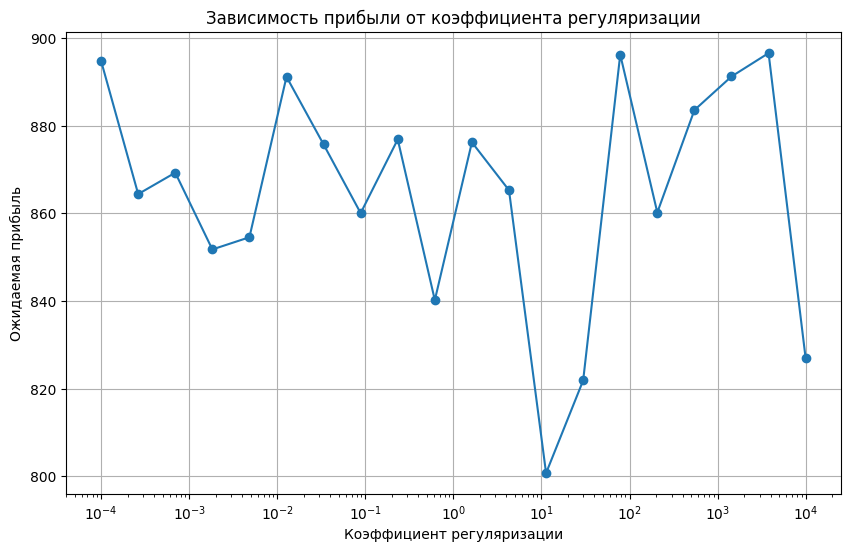

In [293]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, results, marker='o')
plt.xscale('log')  
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Ожидаемая прибыль')
plt.title('Зависимость прибыли от коэффициента регуляризации')
plt.grid(True)
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [295]:
def repeat_experiment(n):
    optimal_C_values = []

    for run in range(n):
        profit_results = cross_validate(X_tr, y)
        optimal_C = C_values[np.argmax(profit_results)]
        optimal_C_values.append(optimal_C)
    
    return optimal_C_values

res = repeat_experiment(5)
print(res)

[3792.690190732246, 0.0018329807108324356, 0.23357214690901212, 4.281332398719396, 0.23357214690901212]


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ для такого бизнеса важнее хорошая полнота(recall). С помощью высокого reacall'a можно получить, что больше клиентов, готовых купить депозит, получат предложение. Это повысит общий объём прибыли, ведь мы не упустим ни одного потенциального клиента.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [313]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    profit_results = []
    best_thresholds = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    C_values = np.logspace(-4, 4, 20)
    
    for C in C_values:
        threshold_profit = []  
        for train_index, test_index in kf.split(X):

            # возьмите датасет и обучите модель
            # your code here
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = LogisticRegression(max_iter=10000, random_state=random_state)

            model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            best_profit_for_fold = -float('inf')
            best_threshold_for_fold = None
            
            for threshold in np.arange(0, 1.01, 0.01):
                y_pred = (y_pred_proba > threshold).astype(int)

                correct_pred = (y_pred == 1) & (y_test == 1)
                plus_cost = np.random.uniform(0, 20, correct_pred.sum()).sum()
                neg_cost = 2 * (y_pred == 1).sum()  
                profit = plus_cost - neg_cost  
                
                if profit > best_profit_for_fold:
                    best_profit_for_fold = profit
                    best_threshold_for_fold = threshold

            threshold_profit.append(best_profit_for_fold)
            best_thresholds.append(best_threshold_for_fold)

        mean_profit = np.mean(threshold_profit)
        mean_threshold = np.mean(best_thresholds)
        profit_results.append((mean_profit, mean_threshold))
        
    # осталось только красиво всё обернуть
    return profit_results

In [314]:
res = cross_validate(X_tr, y)

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [323]:
mean_profits = [i[0] for i in res]
mean_thresholds = [i[1] for i in res]

max_profit_index = np.argmax(mean_profits)
best_threshold = mean_thresholds[max_profit_index]

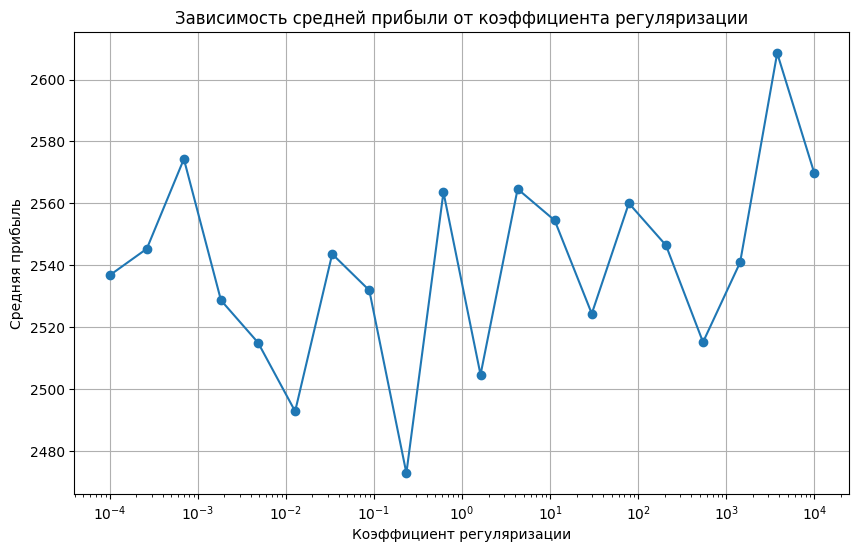

In [316]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, mean_profits, marker='o')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость средней прибыли от коэффициента регуляризации')
plt.grid(True)
plt.show()

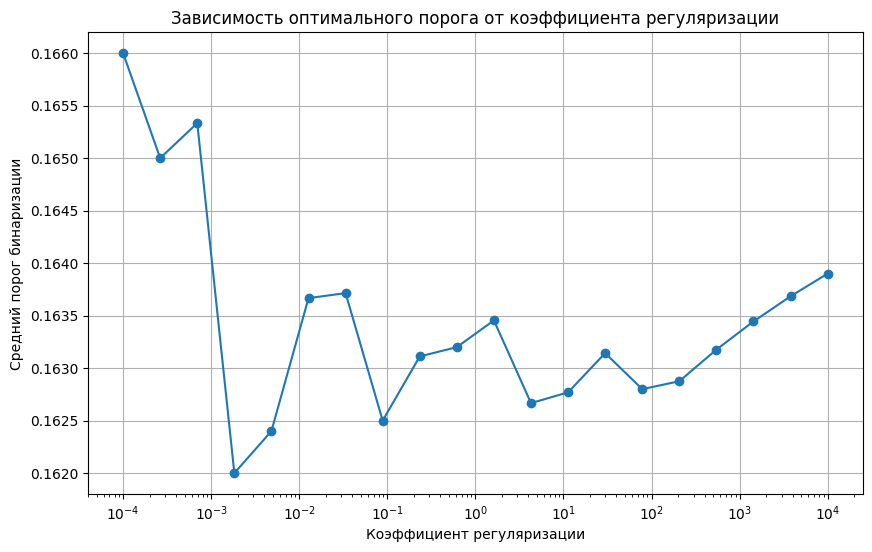

In [317]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, mean_thresholds, marker='o')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Средний порог бинаризации')
plt.title('Зависимость оптимального порога от коэффициента регуляризации')
plt.grid(True)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__  Когда коэффициент регуляризации маленький, модель переобучается и скорее всего будет давать множество ложных положительных предсказаний, поэтому требуется высокий порог для ограничения этих ошибок. Когда коэф регуляризации большой, модель становится более гибкой и делает больше положительных предсказаний, что требует низкого порога, чтобы не упустить клиентов, которые могут согласиться на предложение

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [328]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    profits = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(max_iter=10000, random_state=random_state)
        
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        correct_pred = (y_pred == 1) & (y_test == 1)  
        
        pos_cost = np.random.uniform(0, 20, correct_pred.sum()).sum()
        neg_cost = 2 * (y_pred == 1).sum()  
        profit =  pos_cost - neg_cost
        profits.append(profit)
        

    # осталось только красиво всё обернуть
    return profits
profits = cross_validate(X_tr, y)

In [329]:
def cross_validate_optimized(X, y,best_threshold, n_splits=5, random_state=None, shuffle=False):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    profits = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = LogisticRegression(C=0.23357214690901212, max_iter=10000, random_state=random_state) 
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        y_pred = (y_pred_proba >= best_threshold).astype(int)

        correct_pred = (y_pred == 1) & (y_test == 1)
        plus_cost = np.random.uniform(0, 20, correct_pred.sum()).sum()
        neg_cost = 2 * (y_pred == 1).sum()  
        profit = plus_cost - neg_cost
        profits.append(profit)
        
    return profits

profits_optimized = cross_validate_optimized(X_tr, y, best_threshold)

In [332]:
mean_profits = np.mean(profits)
std_profits = np.std(profits)

mean_profits_optimized = np.mean(profits_optimized)
std_profits_optimized = np.std(profits_optimized)

print("Средняя прибыль для дефолтной модели: ", mean_profits, "Стандартное отклонение: ", std_profits)
print("Средняя прибыль для оптимизированной модели: ", mean_profits_optimized, "Стандартное отклонение: ", std_profits_optimized)

Средняя прибыль для дефолтной модели:  865.5981774790583 Стандартное отклонение:  1631.8523718323934
Средняя прибыль для оптимизированной модели:  2090.1730029864166 Стандартное отклонение:  3944.4658136790085


In [335]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(profits, profits_optimized)
print(p_value)

0.3492958130116461


# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|██████████| 87.2k/87.2k [00:00<00:00, 13.6MB/s]

Extracting files...


Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ яичница:)